In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit
import numpy as np
import copy
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2


In [2]:
iris = datasets.load_iris()
X = iris.data[0:100]  # we only take the first two features.
Y = iris.target[0:100]

X_train, X_test, Y_train, Y_test, = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)


In [3]:
print(Y_train)

[0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [4]:
print(X_train[0])
print (len(Y_train), len(X_train), len(X_test), len(Y_test))

print (X_test)


[5.2 3.4 1.4 0.2]
67 67 33 33
[[6.  2.7 5.1 1.6]
 [5.5 2.3 4.  1.3]
 [5.9 3.2 4.8 1.8]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.9 0.4]
 [5.1 3.4 1.5 0.2]
 [4.6 3.6 1.  0.2]
 [5.5 2.4 3.8 1.1]
 [5.4 3.7 1.5 0.2]
 [5.1 3.5 1.4 0.2]
 [5.7 3.8 1.7 0.3]
 [4.8 3.1 1.6 0.2]
 [6.1 2.8 4.7 1.2]
 [5.5 4.2 1.4 0.2]
 [5.5 2.6 4.4 1.2]
 [5.  3.6 1.4 0.2]
 [6.8 2.8 4.8 1.4]
 [6.7 3.  5.  1.7]
 [4.8 3.  1.4 0.1]
 [5.4 3.4 1.5 0.4]
 [5.7 2.8 4.5 1.3]
 [5.6 3.  4.1 1.3]
 [5.  3.4 1.6 0.4]
 [4.4 3.2 1.3 0.2]
 [5.6 2.5 3.9 1.1]
 [5.7 4.4 1.5 0.4]
 [5.  3.5 1.3 0.3]
 [5.7 2.9 4.2 1.3]
 [4.9 3.1 1.5 0.1]
 [6.3 2.5 4.9 1.5]
 [4.8 3.4 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [6.  3.4 4.5 1.6]]


In [5]:
N = 4
myX_train = [[0 for i in range(N)] for j in range(len(X_train))]
myX_test = [[0 for i in range(N)] for j in range(len(X_test))]



# Correct the size of the features basaed on N

for i in range(len(X_train)): 
    for j in range(N):
        if (j<len(X_train[i])):
            myX_train[i][j]=X_train[i][j] 
        else:
            myX_train[i][j] = 1.0
            
for i in range(len(X_test)): 
    for j in range(N):
        if (j<len(X_test[i])): 
            myX_test[i][j]=X_test[i][j]
        else:
            myX_test[i][j] = 1.0
            

print(myX_test)

[[6.0, 2.7, 5.1, 1.6], [5.5, 2.3, 4.0, 1.3], [5.9, 3.2, 4.8, 1.8], [4.8, 3.0, 1.4, 0.3], [5.1, 3.8, 1.9, 0.4], [5.1, 3.4, 1.5, 0.2], [4.6, 3.6, 1.0, 0.2], [5.5, 2.4, 3.8, 1.1], [5.4, 3.7, 1.5, 0.2], [5.1, 3.5, 1.4, 0.2], [5.7, 3.8, 1.7, 0.3], [4.8, 3.1, 1.6, 0.2], [6.1, 2.8, 4.7, 1.2], [5.5, 4.2, 1.4, 0.2], [5.5, 2.6, 4.4, 1.2], [5.0, 3.6, 1.4, 0.2], [6.8, 2.8, 4.8, 1.4], [6.7, 3.0, 5.0, 1.7], [4.8, 3.0, 1.4, 0.1], [5.4, 3.4, 1.5, 0.4], [5.7, 2.8, 4.5, 1.3], [5.6, 3.0, 4.1, 1.3], [5.0, 3.4, 1.6, 0.4], [4.4, 3.2, 1.3, 0.2], [5.6, 2.5, 3.9, 1.1], [5.7, 4.4, 1.5, 0.4], [5.0, 3.5, 1.3, 0.3], [5.7, 2.9, 4.2, 1.3], [4.9, 3.1, 1.5, 0.1], [6.3, 2.5, 4.9, 1.5], [4.8, 3.4, 1.6, 0.2], [4.6, 3.2, 1.4, 0.2], [6.0, 3.4, 4.5, 1.6]]


In [6]:
def feature_map(X):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    for i, x in enumerate(X):
        qc.rx(x, i)
    return qc, c     


In [7]:
def variational_circuit(qc, theta):
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc    

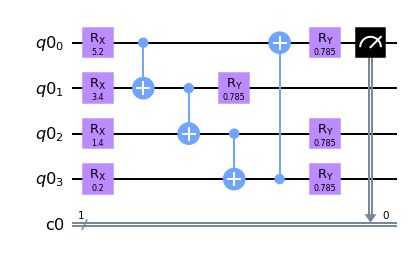

In [8]:
# SSultan Test  

X = [5.2, 3.4, 1.4,0.2]
theta = [0.785]*N
myqc, myc = feature_map(X) 
myqc = variational_circuit(myqc, theta)
myqc.measure(0, myc)
myqc.draw()


In [9]:
def quantum_nn(X, theta, simulator=True):
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0, c)

    shots= 10000
    backend = Aer.get_backend('qasm_simulator')
    if simulator == False:
        shots = 1000
        provider= IBMQ.load_account()
        backend= provider.get_backend('ibmq_bogota')
    
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
           
    return counts['1']/shots
   

In [10]:
def loss(prediction, target):
    return (prediction - target)**2

In [11]:
def gradient (X,Y,theta):
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 =quantum_nn(X,dtheta)
        pred2 =quantum_nn(X,theta)
        
        grad.append((loss(pred1, Y) - loss(pred2, Y)) / delta)
                    
    return np.array(grad)             

In [12]:
def accuracy(X, Y, theta):
    counter = 0
    for i in range(len(X)):
        X_i = X[i]
        Y_i = Y[i]
        prediction = quantum_nn(X_i, theta)
        #pint(X_i, Y_i, prediction)
        if prediction < 0.5 and Y_i == 0:
            counter +=1
        elif prediction >= 0.5 and Y_i == 1 :  
            counter +=1
    return  100.0*counter/len(Y)      

In [13]:
# main program 

eta = 0.05
loss_list = []
acc_list = []
theta = np.ones(N)
print('  Epoch\t  Loss\t  Accuracy')


for k in range(10):
    loss_tmp = []
    
    for i in range(len(myX_train)):
        X_i = myX_train[i]
        Y_i = Y_train[i]
        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction,Y_i))
        theta =theta - eta * gradient(X_i, Y_i, theta)
    loss_list.append(np.mean(loss_tmp))  
    acc = accuracy(myX_train, Y_train, theta)
    acc_list.append(acc)
    print(f'\t{k}\t  {loss_list[-1]:.3f}\t  {acc:.1f}')

  Epoch	  Loss	  Accuracy
	0	  0.291	  13.4
	1	  0.289	  14.9
	2	  0.268	  20.9
	3	  0.246	  73.1
	4	  0.225	  77.6
	5	  0.236	  82.1
	6	  0.235	  86.6
	7	  0.217	  80.6
	8	  0.220	  82.1
	9	  0.206	  80.6


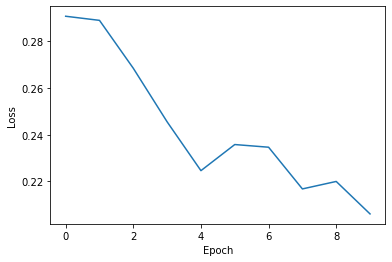

In [14]:
plt1.plot(loss_list)
plt1.xlabel('Epoch')
plt1.ylabel('Loss')
plt1.show()

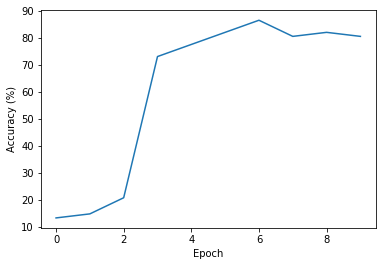

In [15]:
plt2.plot(acc_list)
plt2.xlabel('Epoch')
plt2.ylabel('Accuracy (%)')
plt2.show()


In [16]:
accuracy(myX_test, Y_test, theta)

78.78787878787878

In [17]:
X_sample = myX_test[6]

In [ ]:
print('The predection of the test sample on a simulator:')
quantum_nn(X_sample, theta)

In [ ]:
print('The predection of the test sample (for N = 4) on IBM-Q quantum computer (ibm_bogota):')
quantum_nn(X_sample, theta, simulator = False)